In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Libraries for Video Processing
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


In [ ]:
import cv2
Video_capture=  cv2.VideoCapture("/content/drive/MyDrive/0.001 FYDP dataset/S2.MOV") #2385(shad) #2380(maheen) #2386(mashrur)
co=1;
all_frames=[]
while Video_capture.isOpened():
    ret,frame=Video_capture.read()

    if ret==True:
        if(co>=400): #Loop for frame segmentation
          frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
          all_frames.append(frame) #storing all the frames
        co+=1
    else:
      break
Video_capture.release()
cv2.destroyAllWindows()

In [ ]:
red=[]
green=[]
blue=[]
for i in range(len(all_frames)):
  r,g,b=(all_frames[i].mean(axis=0)).mean(axis=0)
  red.append(r)
  green.append(g)
  blue.append(b)

In [ ]:
# Video Parameters
from scipy.stats import skew, kurtosis
# Frame Quality
#Red
variance_r = np.var(red)
std_dev_r = np.std(red)
skewness_r = skew(red)
kurt_r = kurtosis(red)
#Blue
variance_b = np.var(blue)
std_dev_b = np.std(blue)
skewness_b = skew(blue)
kurt_b = kurtosis(blue)
#Green
variance_g = np.var(green)
std_dev_g = np.std(green)
skewness_g = skew(green)
kurt_g = kurtosis(green)
# Print the result for Frames
print("Parameters of Red Channel")
print("Variance:", variance_r)
print("Standard deviation::", std_dev_r)
print("Skewness:", skewness_r)
print("Kurtosis:", kurt_r)
print("Parameters of Blue Channel")
print("Variance:", variance_b)
print("Standard deviation::", std_dev_b)
print("Skewness:", skewness_b)
print("Kurtosis:", kurt_b)
print("Parameters of Green Channel")
print("Variance:", variance_g)
print("Standard deviation::", std_dev_g)
print("Skewness:", skewness_g)
print("Kurtosis:", kurt_g)

Parameters of Red Channel
Variance: 5.557208415358756
Standard deviation:: 2.357373202392603
Skewness: -0.18102042056865664
Kurtosis: -0.8043530114639337
Parameters of Blue Channel
Variance: 0.017937298725726622
Standard deviation:: 0.13393020094708522
Skewness: -0.5138489110031765
Kurtosis: -0.47362468272393876
Parameters of Green Channel
Variance: 2.9828472371722703
Standard deviation:: 1.7270921333768707
Skewness: -0.7585150393775824
Kurtosis: -0.42406240784674676


In [ ]:
# Future work for video quality insepction - we derived this algorithm by utilzing inequality equation from G. Zhang's published frame selection criteria
# Before pre-processing we wanted to inspect video quality.  For publication , this needs more research

Rm = (np.mean(red))*1.17
Rs = np.std(red)
Gm = (np.mean(green))*0.015
Bm = np.mean(blue)
if (Rm>=240 and Rs<=20 and Gm<1 and Bm<75):
  print('Video is minimially  Corrupted by artifacts')
else:
  print('Video significantly Corrupted by artifacts')

m = np.mean(red)
Threshold = (1.01*(np.max(red)-np.min(red)))*0.4
if m>Threshold:
  print('Video has been recorded successfully')
else:
  print('Unexpected Error during Video recording ')


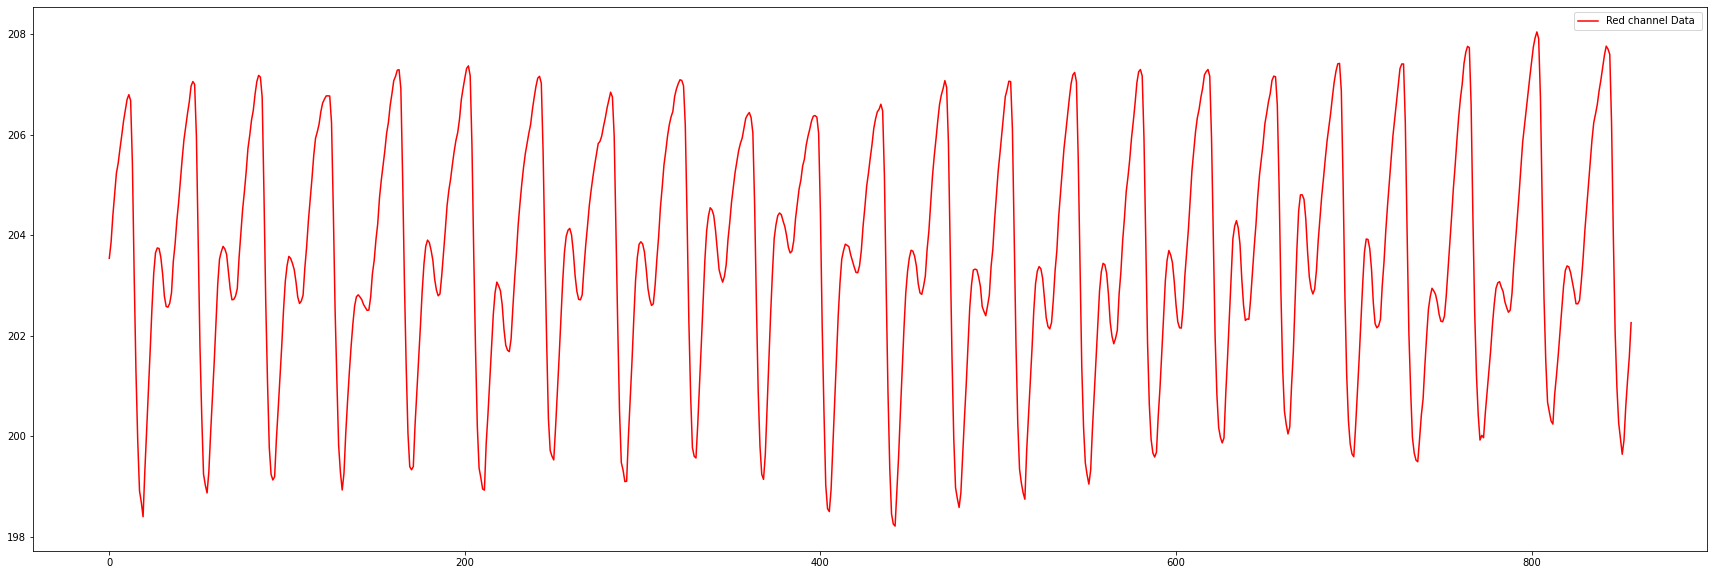

In [ ]:
# Red Channel Data from the video plotted against frames of video
plt.figure(figsize=(30,10))
plt.plot(red, color='r',label='Red channel Data ')
plt.legend()
plt.show()

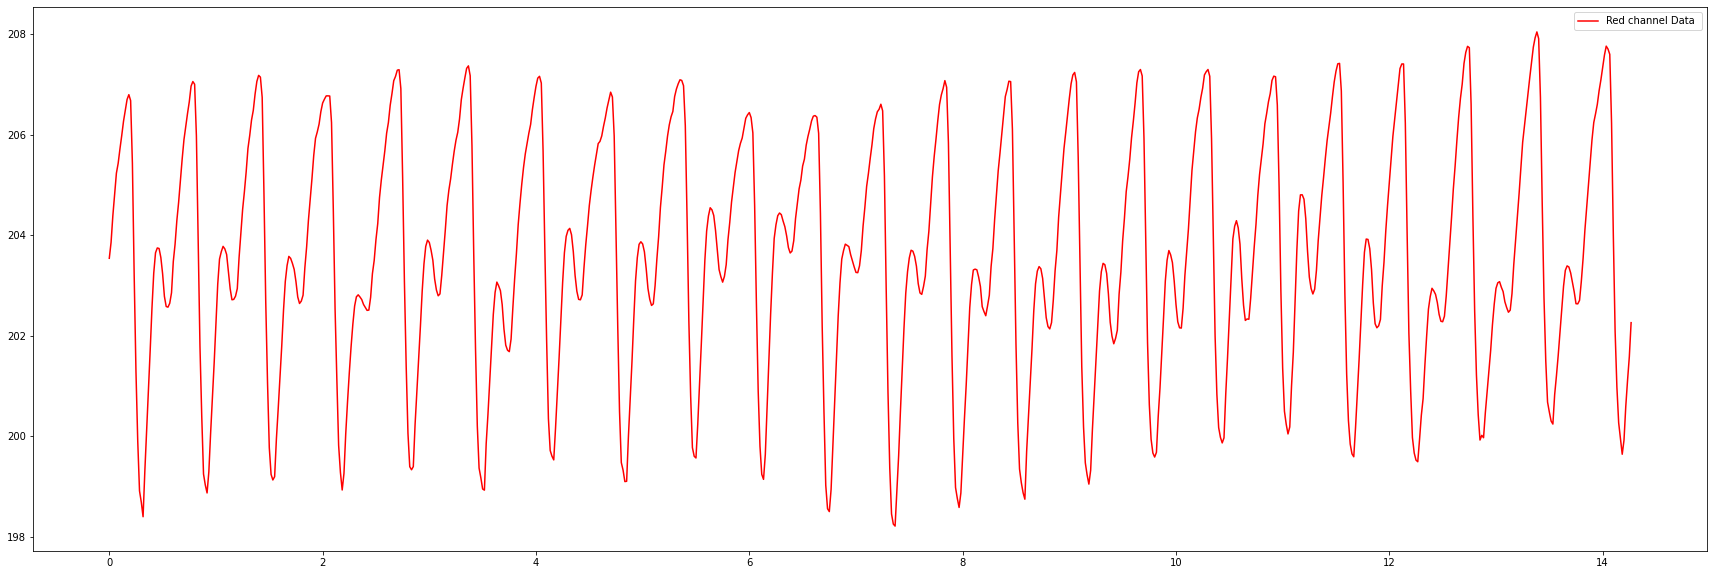

In [ ]:
#Extracted PPG signal plotted against time
t_vid=[(i)/60 for i in range(0,len(red))] #time in seconds
plt.figure(figsize=(30,10))
plt.plot(t_vid,red, color='r',label='Extracted PPG signal from fingertip video ')
plt.legend()
plt.show()

In [ ]:
Red=np.array(red).reshape(1, -1)
Blue=np.array(blue).reshape(1, -1)
Green=np.array(green).reshape(1, -1)

In [ ]:
# Wavelet Denoising
from skimage.restoration import denoise_wavelet
signal = Red.flatten()
var_signal=np.var(signal)
wav_denoise=denoise_wavelet(signal,method='BayesShrink', mode='soft',wavelet_levels=6,wavelet='sym8',rescale_sigma='True')

/usr/local/lib/python3.9/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


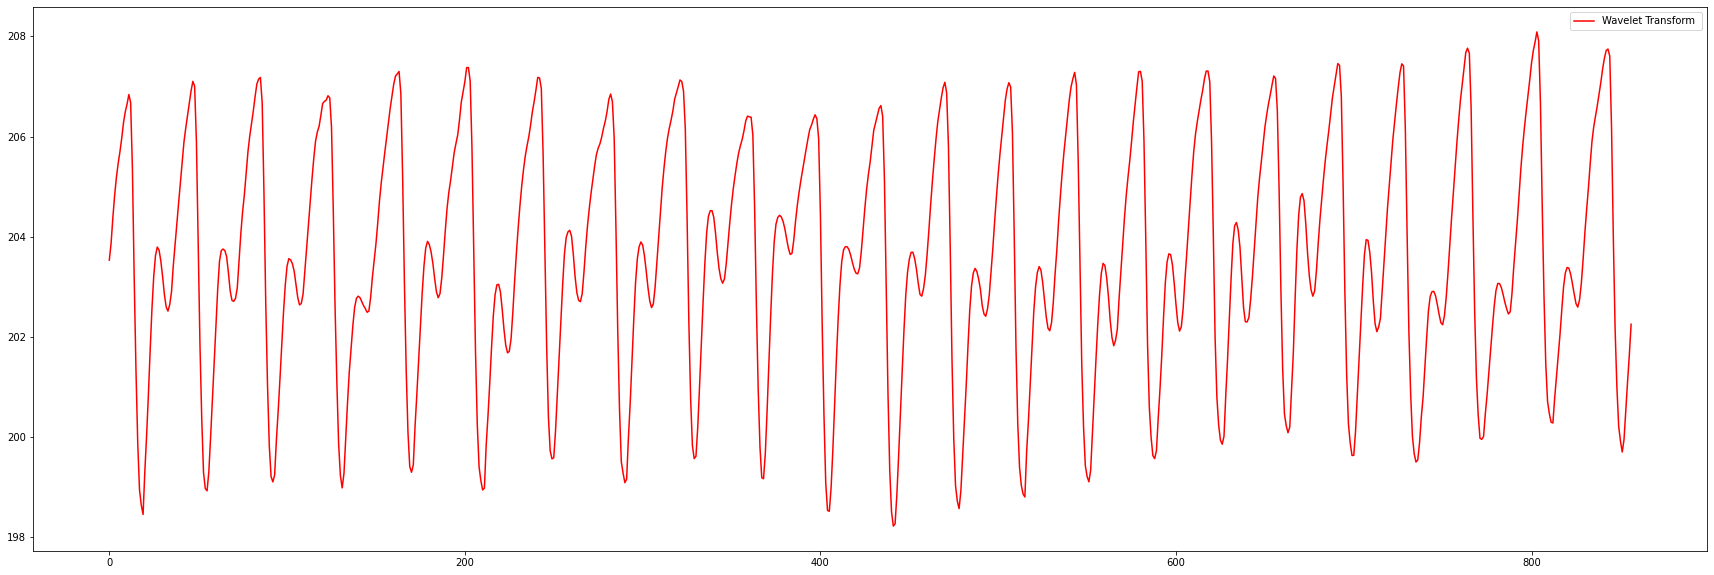

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(wav_denoise, color='r',label='Wavelet Transform ')
plt.legend()
plt.show()

In [ ]:
t=[(i)/60 for i in range(0,len(wav_denoise))] #time in seconds

In [ ]:
from scipy import signal
detrended = signal.detrend(wav_denoise)

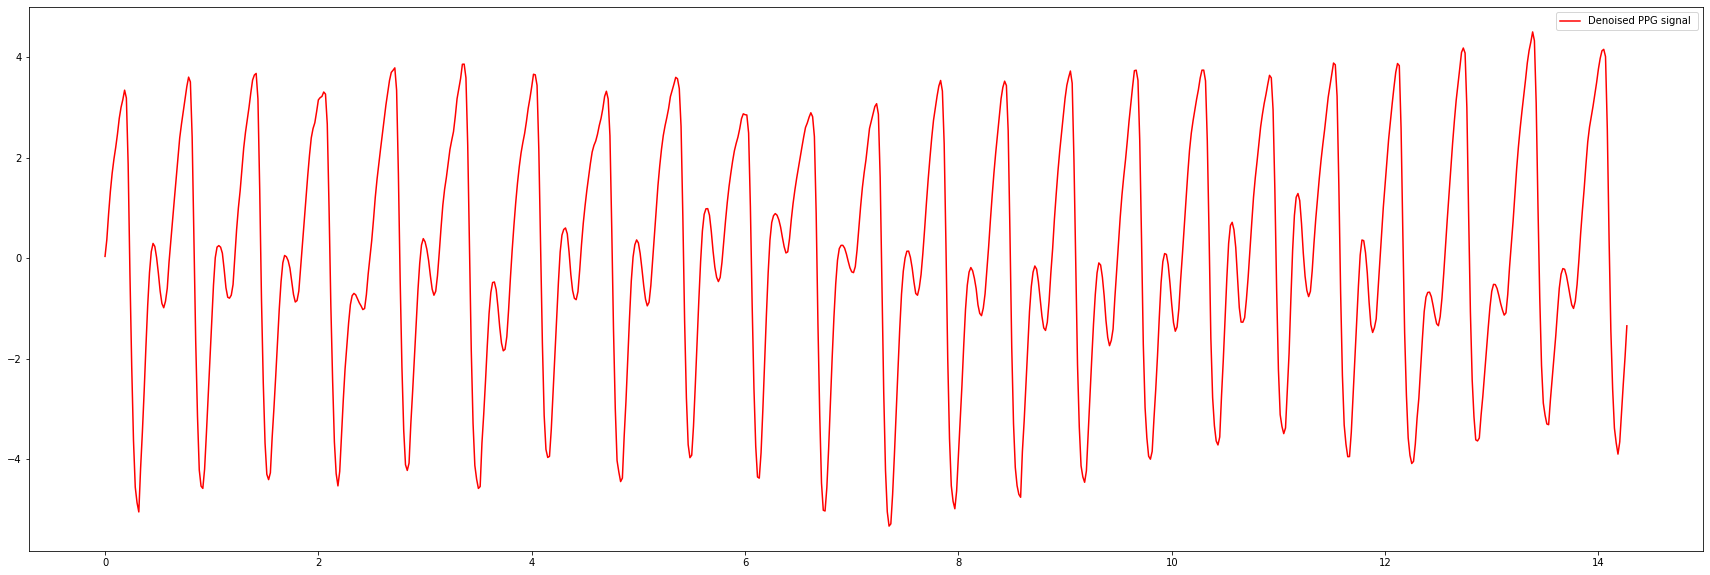

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(t,detrended, color='r',label='Denoised PPG signal ')
plt.legend()
plt.show()

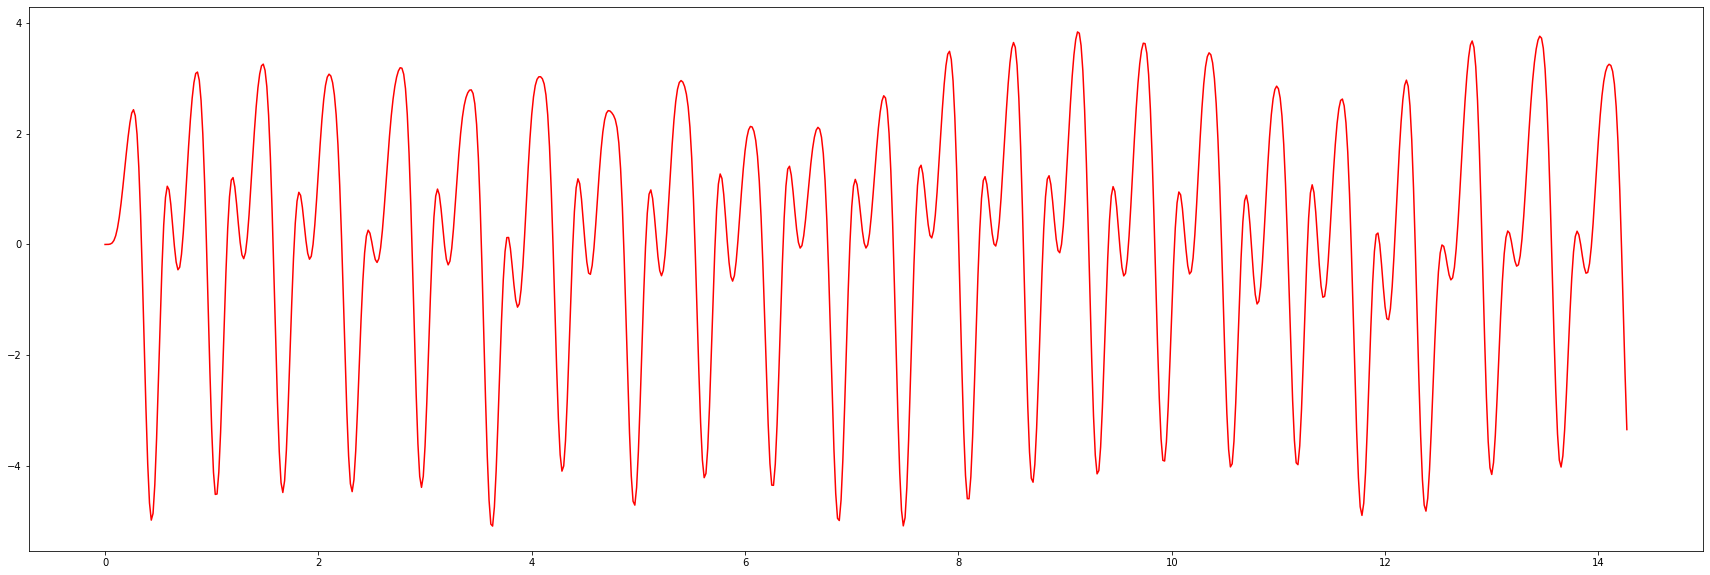

In [ ]:
# Bandpass Filter
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in Hz).
fs = 60
lowcut = 0.1
highcut = 4.5 #4.5 #6


sig_bp1 = butter_bandpass_filter(detrended, lowcut, highcut, fs, order=5)

plt.figure(figsize=(30,10))
plt.plot(t,sig_bp1, color='r',label='Filter: Bandpass ')
plt.show()

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


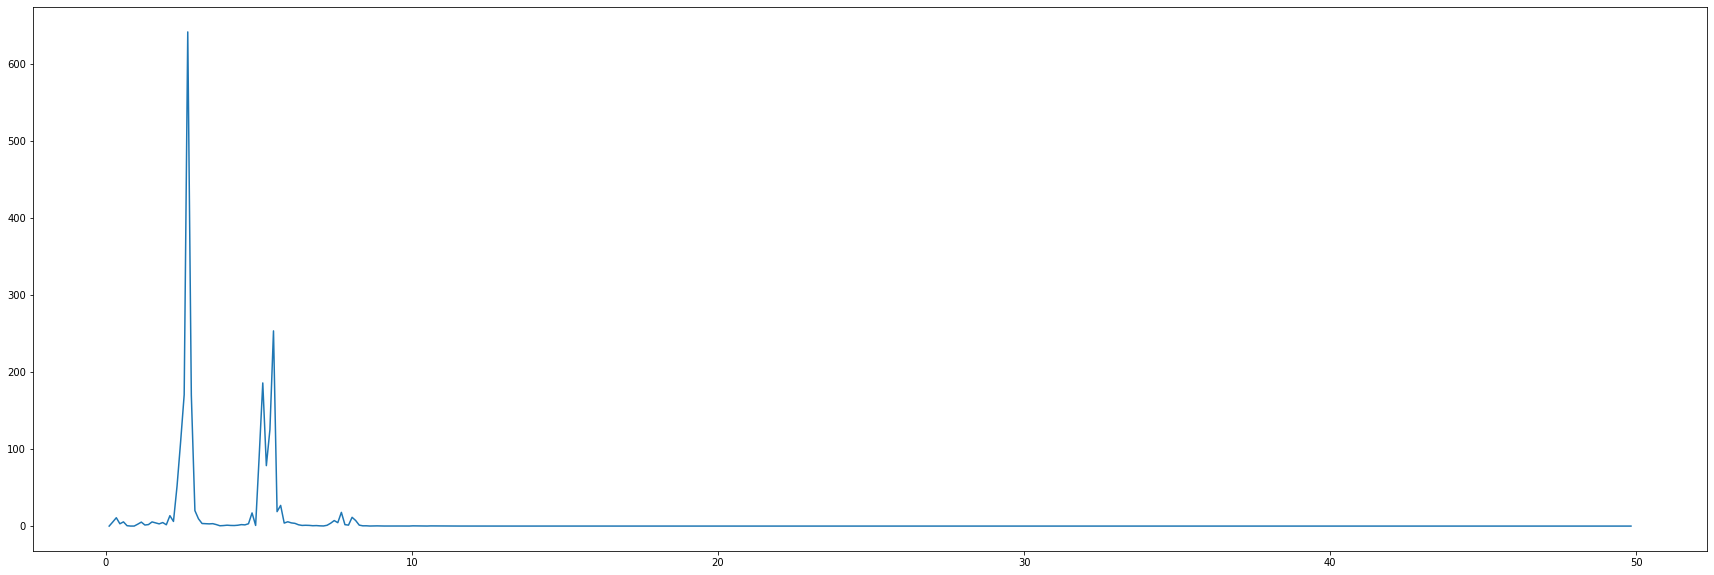

In [ ]:
# Fast fourier Transform
dt = 0.01
n2= len(t)
fhat = np.fft.fft(sig_bp1,n2)
PSD = fhat * np.conj(fhat)/n2
freq = (1/(dt*n2)) * np.arange(n2)
L = np.arange( 1,np.floor(n2/2),dtype='int')
plt.figure(figsize=(30,10))
plt.plot(freq[L],PSD[L])

In [ ]:
!pip install pybaselines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 3.6 MB/s eta 0:00:00


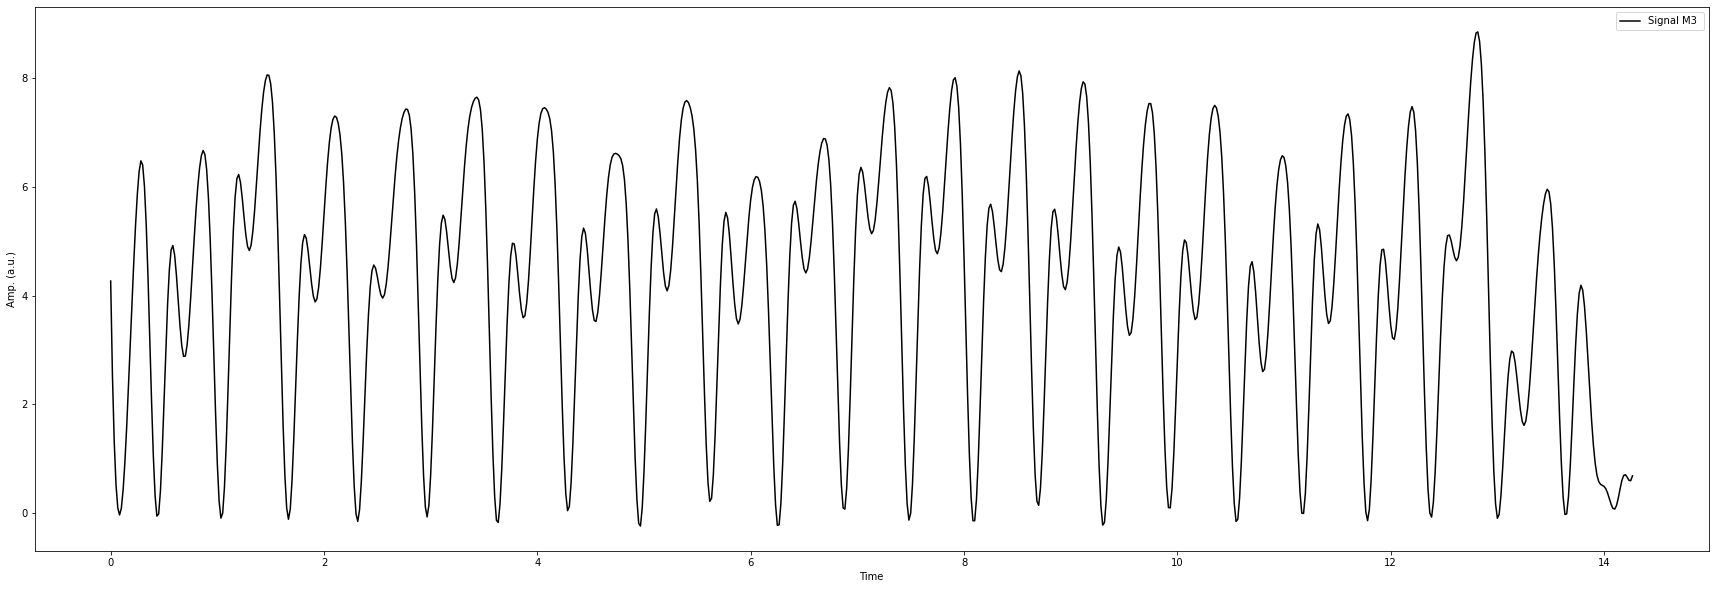

In [ ]:
# Baseline Correction by polynomial fitting
from pybaselines import Baseline
baseline_fitter = Baseline(x_data=t)
bc = sig_bp1-baseline_fitter.modpoly(sig_bp1,poly_order=26)[0]
plt.figure(figsize=(30,10))
plt.plot(t,bc,'k',label='Signal M3 ')
plt.xlabel('Time')
plt.ylabel('Amp. (a.u.)')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import skew, kurtosis
# Signal Quality
variance = np.var(bc)
std_dev = np.std(bc)
skewness = skew(bc)
kurt = kurtosis(bc)
# Print the result
print("Parameters of Signal_M3")
print("Variance:", variance)
print("Standard deviation::", std_dev)
print("Skewness:", skewness)
print("Kurtosis:", kurt)

Parameters of Signal_M3
Variance: 5.433738927728775
Standard deviation:: 2.33103816522355
Skewness: -0.30761601726448046
Kurtosis: -0.9206234439703538


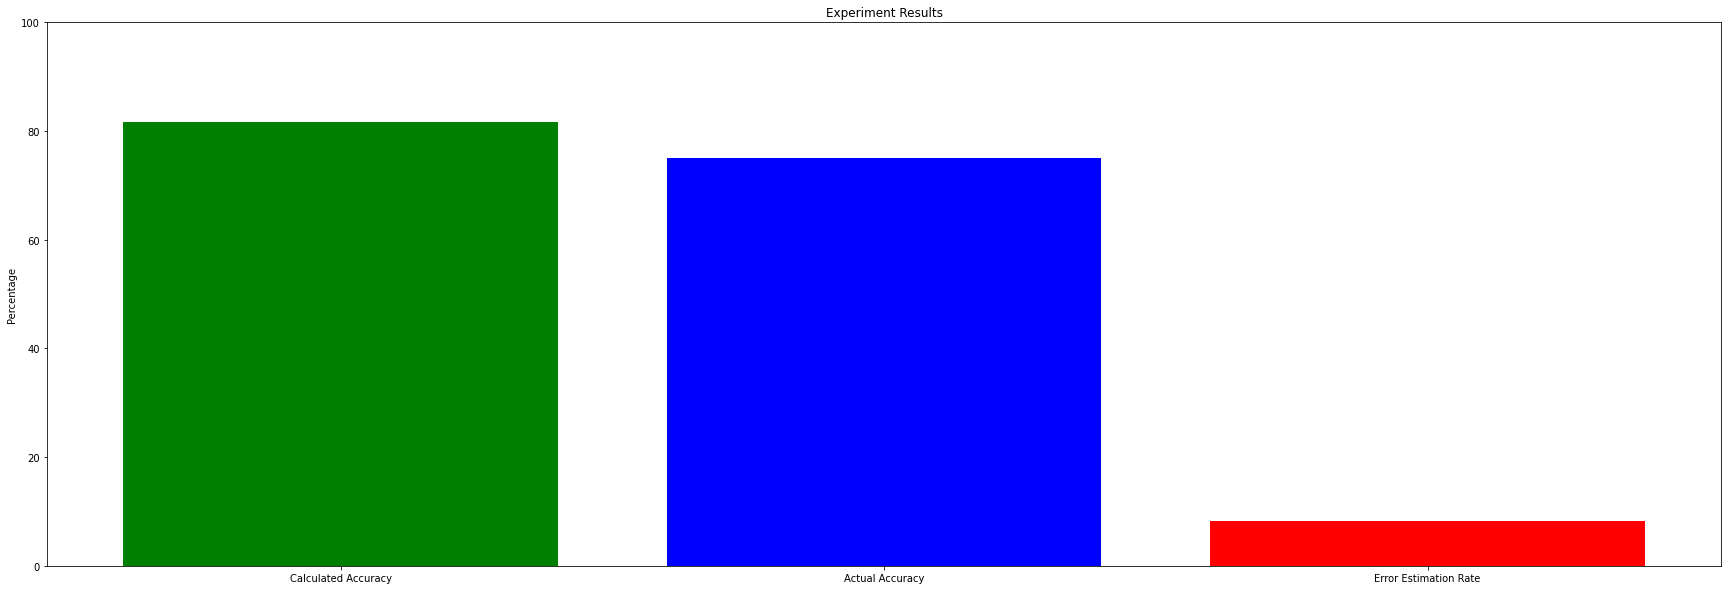

In [ ]:
# Overall performance of our framework
import numpy as np
import matplotlib.pyplot as plt

# Define the data as NumPy arrays
calculated_accuracy = np.array([81.68])
actual_accuracy = np.array([74.96])
error_estimation_rate = np.array([8.22])

# Define the x-axis labels
labels = ['Calculated Accuracy', 'Actual Accuracy', 'Error Estimation Rate']

# Set the figure size
plt.figure(figsize=(30, 10))

# Set the colors for each bar
colors = ['green', 'blue', 'red']

# Create the bar plot
plt.bar(labels, [calculated_accuracy[0], actual_accuracy[0], error_estimation_rate[0]], color=colors)

# Set the y-axis limits and title
plt.ylim(0, 100)
plt.ylabel('Percentage')
plt.title('Experiment Results')

# Show the plot
plt.show()